# Text Mining experiment with GitHub issue
- Extract text information from Github issue avaible in .csv
- Preprocess issue (tokenizer-stopwords- lemmatization)
- Generation of topic models and issue corpus(tf,tf-id) for the different algorithms (LSI,LDA,HDP,LDAMALLET).
- Evaluation document characterizacion : Topic model vs TF_IDF
    - Evaluate classifier MultinomialNB
    - Evaluate classifier with multiclass SVN DecisionTreeClassifier
    - Evaluate classifier MultinomialNB with Binary
    - Evaluate classifier MultiLabel: DecisionTreeClassifier

## Load  the csv files with the issues available in./datasets/issue/ 

In [1]:
## Load issue
import os
import glob
import pandas as pd
#Read csv
def loadCsvPullRequestFolder(path):
    """Load issue data from  csv files  and generate a 
    list with all issue
    Parameters:
        ----------
        path : folder path with csv file issue information. 
            id issue
            title issue test
            body issue test
            commentsBodies test
            'Label category: bug' text boolean is bug
            isLabeled text boolean 
            isPullRequest text boolean
     Returns:
        -------  
        _totalfile number of file read
        len(_liss) number of issue read
        _liss list of total issues
        dftotal dataframe with total issues   
        
    """
    _liss=list()
    _totalfile=0
    dftotal=pd.DataFrame()
    for filename in glob.glob(os.path.join(path, '*.csv')):        
        print(filename)
        df2=pd.read_csv(filename, error_bad_lines=False, index_col=False, dtype='unicode')
        df2["issuetext"] = df2["title"].map(str) + " " + \
        df2["body"].map(str)
        #df2["commentsBodies"].map(str)
        
        [_liss.append(issue) for issue in df2.issuetext] 
        _totalfile+=1
        dftotal=dftotal.append(df2)
    dftotal.rename(columns={"'Label category: bug'":'bug'}, inplace=True)    
        #print(lprbt[len(lprbt)-1])
    del dftotal['body']  
    del dftotal['id'] 
    del dftotal['commentsBodies']
    del dftotal['title']
    
    return _totalfile, len(_liss), _liss, dftotal


totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/issue/")   
print("Number of files: {} Number of instances in list: {}".format(totalfiles,totalinstances))
print("Number of instance in dataframe {}".format(df.shape[0]))
df.tail(2)

./datasets/issue/all-issues_chartjs.arff.csv
./datasets/issue/all-issues_angularjs.arff.csv
Number of files: 2 Number of instances in list: 20586
Number of instance in dataframe 20586


,bug,isLabeled,isPullRequest,issuetext,number,repo
16074,false,false,false,'' '',16112,angular.js
16075,false,false,false,'Custom string to integer directive no value i...,16113,angular.js


## Preprocess issue (tokenizer-stopwords- lemmatization)
Library spaCy first tokenizes the text to produce a Doc object. 
The Doc is then processed in several different steps – this is also referred to as the processing pipeline. 
The pipeline used by the default models consists of a tagger, a parser and an entity recognizer. 
Each pipeline component returns the processed Doc, which is then passed on to the next component.

In [2]:
##Preprocessing data
import LibraryTopicModel as ltm
import spacy

lprbt=ltm.textNormalization(lprbt)                
prwords=list(ltm.pr_to_words(lprbt))
print("Numbers of tokens in issue: {} ".format(ltm.counterElements(prwords)))
data_words_nostops = ltm.remove_stopwords(prwords)
print("Numbers of tokens in issue with out nostops: {} ".format(ltm.counterElements(data_words_nostops)))
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized = ltm.lemmatization(nlp,data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("Numbers of tokens in issue after lemmatization: {} ".format(ltm.counterElements(data_lemmatized)))

Numbers of tokens in issue: 1709447 
Numbers of tokens in issue with out nostops: 1144807 
CPU times: user 6min 36s, sys: 6.16 s, total: 6min 42s
Wall time: 3min 53s
Numbers of tokens in issue after lemmatization: 1067589 


## Generation of topic models and issue corpus for the different algorithms (LSI,LDA,HDP,LDAMALLET).
Models and corpus are stored in folder ./models/issue/.
In our case study we'll use LDAMALLET implementation

In [3]:
## Creating corpus an dictionary
import gensim.models.tfidfmodel as tfidmodel
import gensim.models.tfidfmodel as tfidf
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel
import gensim.models.wrappers.ldamallet as ldamallet
import gensim.models.hdpmodel as hdpmodel


#save dictionary
def createCorpusDictionary(data_lemmatized):
    """Create a corpus (TF and TF-IDF from issues preprocessed (tokenized and lemmatized).
    Corpus and dictinary are saved in files.
    Parameters:
        ----------
        data_lemmatized : data preprocessed 
     Returns:
        -------  
        corpus - document word representation TF-IDF
        id2word - dictionary 
     """   
    id2word = corpora.Dictionary(data_lemmatized)
    #Let's filter out both very infrequent words and very frequent words (stopwords), to clear up resources as well as remove noise.
    #ignore words that appear in less than 20 documents or more than 10% documents
    id2word.filter_extremes(no_below=10, no_above=0.1)
    id2word.save('./models/issue/dict_issues')
    id2word.save_as_text('./models/issue/dict_issues.txt')
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('./models/issue/istfcorpus.mm', corpus)
    return corpus,id2word

def createCorpusTfid(corpus):
    tfidf = tfidmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    corpora.MmCorpus.serialize('./models/issue/istfidcorpus.mm',corpus_tfidf )
    return corpus_tfidf

def createLDA(corpus, id2word):
    ldamodeliss = ldamodel.LdaModel(corpus, id2word=id2word, num_topics=10)
    #ldamodelpr.print_topics(2)
    ldamodeliss.save("./models/issue/ldamodeliss")
    corpora.MmCorpus.serialize('./models/issue/isldatfidcorpus.mm',ldamodeliss[corpus])
    return ldamodeliss 


def createLDAMallet(corpus, id2word):
    mallet_path="./mallet-2.0.8/bin/mallet"
    ldamalletmodeliss = ldamallet.LdaMallet(mallet_path,corpus,id2word=id2word, num_topics=10)
    #ldamodelpr.print_topics(2)
    ldamalletmodeliss.save("./models/issue/ldamalletmodeliss")
    corpora.MmCorpus.serialize('./models/issue/isldamallettfidcorpus.mm',ldamalletmodeliss[corpus])
    return ldamalletmodeliss 

def createHDP(corpus, id2word):
    hdpmodeliss = hdpmodel.HdpModel(corpus, id2word=id2word)
    hdpmodeliss.save("./models/issue/hpdmodeliss")
    corpora.MmCorpus.serialize('./models/issue/ishpdtfidcorpus.mm',hdpmodeliss[corpus])
    return  hdpmodeliss  

corpus,dictionary=createCorpusDictionary(data_lemmatized)

%time tfid=createCorpusTfid(corpus)
#%time ldamodel_is=createLDA(corpus,dictionary)
%time ldatfid_is=createLDA(tfid,dictionary)
%time ldamallettfid_is=createLDAMallet(tfid,dictionary)
%time hdptfid_is=createHDP(tfid,dictionary)

CPU times: user 7.82 s, sys: 76 ms, total: 7.9 s
Wall time: 8.03 s
CPU times: user 48.7 s, sys: 268 ms, total: 49 s
Wall time: 46.1 s
CPU times: user 14.4 s, sys: 236 ms, total: 14.6 s
Wall time: 54.9 s
CPU times: user 14min 53s, sys: 14.9 s, total: 15min 8s
Wall time: 10min 11s


### Information about each corpus 
It can be seen that feature reduction when topic modeling is applied. 

In [4]:
tf_mm_corpus = corpora.MmCorpus('./models/issue/istfcorpus.mm')
print(tf_mm_corpus)
tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
print(tfid_mm_corpus)
ldatfid_mm_corpus = corpora.MmCorpus('./models/issue/isldatfidcorpus.mm')
print(ldatfid_is)
print(ldatfid_mm_corpus)
ldamallettfid_mm_corpus = corpora.MmCorpus('./models/issue/isldamallettfidcorpus.mm')
print(ldamallettfid_is)
print(ldamallettfid_mm_corpus)
hdptfid_mm_corpus = corpora.MmCorpus('./models/issue/ishpdtfidcorpus.mm')
print(hdptfid_is)
print(hdptfid_mm_corpus)


MmCorpus(20586 documents, 3509 features, 466236 non-zero entries)
MmCorpus(20586 documents, 3509 features, 466236 non-zero entries)
LdaModel(num_terms=3509, num_topics=10, decay=0.5, chunksize=2000)
MmCorpus(20586 documents, 10 features, 205793 non-zero entries)
MmCorpus(20586 documents, 10 features, 205860 non-zero entries)
MmCorpus(20586 documents, 150 features, 23270 non-zero entries)


# Visualization topic models - issues

- __Serializable inputs in folder models__ 
    - several serialized topic models (rpmdelpr,ldamodelpr, lsimodelpr, hpdmodelpr) gets with pull request datasets and dictionary of pull request 
    - corpus pull request prcorpus
    - dictionary  
- __Output__ Graphical representation of topics in topic models

__Visualization only work with lda and hpd models__   

In [5]:
# Visualice LDA model
import gensim
import gensim.models.ldamodel as ldamodel
import gensim.corpora as corpora


# Load persistent LDA model
ldamodeliss =ldamodel.LdaModel.load("./models/issue/ldamodeliss")
#Load dictionary
dictionary= gensim.corpora.Dictionary.load_from_text("./models/issue/dict_issues.txt")
#Load corpus
corpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")


# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vislda = pyLDAvis.gensim.prepare(ldamodeliss, corpus, dictionary)
vislda


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      23.235363        1       1 -0.052799  0.075056
8      21.286600        1       2 -0.062701 -0.061087
4      14.939801        1       3  0.040443 -0.233566
1       9.870827        1       4  0.078426  0.069896
2       5.569161        1       5 -0.083974 -0.144567
7       5.051247        1       6 -0.067636  0.024758
0       5.036060        1       7  0.291621  0.017723
9       5.009033        1       8  0.030352  0.086751
6       5.001872        1       9 -0.083377  0.106334
5       5.000044        1      10 -0.090354  0.058702, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
3162  Default   82.000000          timeout   82.000000  30.0000  30.0000
3263  Default   97.000000             typo   97.000000  29.0000  29.0000
2329  Default   91.000000            plnkr   91.000000  28.0000  28.0000
1132  Default  112.000000          feature  112.000000  27.0000  27.0000
469   Default  107.000000          channel  107.000000  26.0000  26.0000
2779  Default   71.000000           select   71.000000  25.0000  25.0000
2897  Default   47.000000         snapshot   47.000000  24.0000  24.0000
542   Default   83.000000               co   83.000000  23.0000  23.0000
582   Default   52.000000          compile   52.000000  22.0000  22.0000
2441  Default   83.000000          promise   83.000000  21.0000  21.0000
2622  Default   75.000000           report   75.000000  20.0000  20.0000
2960  Default   42.000000       stacktrace   42.000000  19.0000  19.0000
3203  Default   36.000000              tpl   36.000000  18.0000  18.0000
1850  Default   56.000000          message   56.000000  17.0000  17.0000
565   Default   65.000000           commit   65.000000  16.0000  16.0000
1565  Default   51.000000        introduce   51.000000  15.0000  15.0000
2187  Default   58.000000           option   58.000000  14.0000  14.0000
2410  Default   49.000000          preview   49.000000  13.0000  13.0000
1561  Default   32.000000      interpolate   32.000000  12.0000  12.0000
663   Default   47.000000       contribute   47.000000  11.0000  11.0000
483   Default   50.000000         checkbox   50.000000  10.0000  10.0000
1905  Default   33.000000            model   33.000000   9.0000   9.0000
2057  Default   44.000000         ngoption   44.000000   8.0000   8.0000
497   Default   43.000000            chore   43.000000   7.0000   7.0000
1506  Default   24.000000           inject   24.000000   6.0000   6.0000
2239  Default   64.000000            param   64.000000   5.0000   5.0000
1509  Default   32.000000         injector   32.000000   4.0000   4.0000
2629  Default   38.000000        reproduce   38.000000   3.0000   3.0000
2411  Default   54.000000         previous   54.000000   2.0000   2.0000
1337  Default   28.000000        guideline   28.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
2914  Topic10    1.683025         somewhat    1.999094   2.8236  -6.4160
3364  Topic10    1.726385          valueof    2.056596   2.8207  -6.3906
3214  Topic10    4.701587        transclud    5.603107   2.8203  -5.3887
1905  Topic10   23.256237            model   33.055725   2.6441  -3.7900
2025  Topic10    5.157691          ngclass    6.918064   2.7021  -5.2961
2779  Topic10   40.807785           select   71.982491   2.4282  -3.2277
1309  Topic10    4.970580       googleapis    7.067813   2.6437  -5.3331
2187  Topic10   26.705530           option   58.634113   2.2093  -3.6517
1955  Topic10    5.449140            myapp    8.265596   2.5791  -5.2411
119   Topic10    5.660634       animatecss    9.233956   2.5064  -5.2031
2296  Topic10    4.708366  petebacondarwin    7.223678   2.5677  -5.3873
1847  Topic10    7.357342            merge   15.798847   2.2315  -4.9409
75    Topic10    7.40792

## Evaluation document characterizacion : Topic model vs TF_IDF

To evaluate the quality of the new corpus created with LDAMallet we use the same strategy as the one generated in the following article paper Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf).
We load persistence corpus TF-IDF and LDA to reduce cpu time.
Then we tested differrent classifier  MultinomialNB, DecisionTreeClassifier in several ways, Binary Relevance, Multiclass and multilabel to classify the follows issue features:
- issue.repo,issue.isLabeled, issue.bug,issue.isPullRequest

Github repositories f.replace('jquerytools', 0).replace('Chart.js', 1).replace('netty', 2).replace('RxJava', 3).replace('cakephp', 4).replace('angular.js', 5)

We use F-measure, ROC, accuracy and hamming_loss to evaluate classifier.

- [Paper Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
In the text classification problem, we wish to classify a document into two or more mutually exclusive classes. 
A challenging aspect of the document classification problem is the choice of features. Treating
individual words as features yields a rich but very large feature set (Joachims, 1999).  One way to
reduce this feature set is to use an LDA model for dimensionality reduction.  In particular, LDA 
reduces  any  document  to  a  fixed  set  of  real-valued  features—the  posterior  Dirichlet  parameters
γ(w) associated with the document.  
It is of interest to see how much discriminatory information we lose in reducing the document description to these parameters.
We  conducted  two  binary  classification  experiments  using  the  Issues  dataset.   The
dataset contains 36412 issues and 1917159 words. 
In  these  experiments,  we  estimated  the  parameters  of  an  LDA  model  on  all  the  documents,
without reference to their true class label. We then trained a Multinomial Naive Bayes (MNB) on the
low-dimensional representations provided by LDA and compared this MNB to an MNB trained on
all the word features.
Using scikit-learn machine learning learning in Python, we compared an MNB trained on all
the word features with those trained on features induced by a 20-topic LDA model.  Note that we
reduce the feature space by 99.6 percent in this case.

### Evaluate classifier MultinomialNB

Preconditions
- use a classifier MNB SVM could be used.
- use a metric no multiclass (micro, macro)

 Data binary to classify class: issue.repo,issue.isLabeled, issue.bug,issue.isPullRequest

Example issue.repo for two repoitories
  
df.replace('jquerytools', 0).replace('Chart.js', 1)

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import gensim
import pandas as pd


#lda gensim version
#ldacorpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")
#svlda=gensim.matutils.corpus2csc(ldacorpus)
#lda mallet version
ldacorpus = corpora.MmCorpus("./models/issue/isldamallettfidcorpus.mm")
svlda=gensim.matutils.corpus2csc(ldacorpus)
#hdp version
#hdpcorpus = corpora.MmCorpus('./models/issue/ishpdtfidcorpus.mm')
#svlda=gensim.matutils.corpus2csc(hdpcorpus)

tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
svtfid=gensim.matutils.corpus2csc(tfid_mm_corpus)

totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/issue/") 

df = df.replace('true', 1).replace('false', 0)


# Calcula F-Measure iterativamente obtenida con claificador Multinomial
# se analiza reduciendo el porcentaje de entrenamiento
def trainCorpusEvaluate(df,str_y_columname,x_transformations):
    """Create a MNB classifier and it is trained iterative from train_size 1% to 40%.
    Measure are calculated FMeasure, Roc, hamming_loss,accuracy
    Parameters:
    ----------
    df: dataframe with issue information
    x_transformations : sparse vector with the corpus
    str_y_columname: binary class name in dataframe 
    Returns:
    -------  
    dfresult - list with measures values for each tarined set
    """   
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
    #dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,40,1):
            train_size=i/100
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[str_y_columname]), train_size=train_size, random_state = 0)
            clf = MultinomialNB().fit(X_train, y_train)
            #clf = svm.SVC().fit(X_train, y_train)
            #clf= DecisionTreeClassifier().fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            #f1=f1_score(y_test,y_test_predicted,average='macro')
            f1=f1_score(y_test,y_test_predicted)
            roc=roc_auc_score(y_test,y_test_predicted)
            hamming=hamming_loss(y_test,y_test_predicted)
            accuracy=accuracy_score(y_test, y_test_predicted, normalize=True, sample_weight=None)
            #print("train_size: {} transformation[0]: {} ,f1: {}".format(train_size,transformation[0],f1))
            dfaux=pd.DataFrame([[train_size,transformation[0],f1,roc,hamming,accuracy]],columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
            #dfaux=pd.DataFrame([[train_size,transformation[0],f1,hamming]],columns=["% train","transformation","F-measure","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

#liststrLabelY=['repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
liststrLabelY=['isLabeled']
dfresulty=[]

for strylabel in liststrLabelY:
    dfresultyaux=trainCorpusEvaluate(df, strylabel,[["tfid",svtfid],["lda",svlda]])
    dfresulty+=[dfresultyaux]
    
print(dfresulty)

./datasets/issue/all-issues_chartjs.arff.csv
./datasets/issue/all-issues_angularjs.arff.csv


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[    % train transformation  F-measure  roc_auc_score  hamming_loss  accuracy
0      0.01           tfid   0.771321       0.500875      0.371670  0.628330
0      0.02           tfid   0.771156       0.501350      0.371698  0.628302
0      0.03           tfid   0.770602       0.503480      0.371225  0.628775
0      0.04           tfid   0.770645       0.503713      0.371148  0.628852
0      0.05           tfid   0.770812       0.504946      0.370507  0.629493
0      0.06           tfid   0.770200       0.504367      0.371402  0.628598
0      0.07           tfid   0.770370       0.505424      0.370802  0.629198
0      0.08           tfid   0.769423       0.506771      0.370908  0.629092
0      0.09           tfid   0.769093       0.507498      0.370876  0.629124
0      0.10           tfid   0.768656       0.507574      0.371276  0.628724
0      0.11           tfid   0.768853       0.508859      0.370374  0.629626
0      0.12           tfid   0.768507       0.511526      0.369232  0.63076

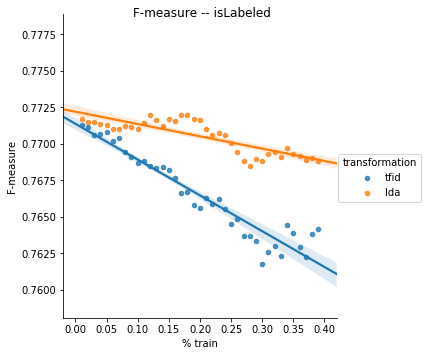

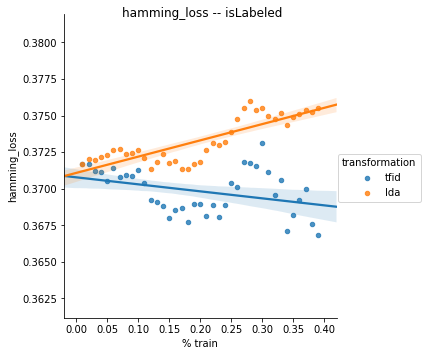

In [9]:
import pandas as pd
import seaborn as sns

#"BinaryRelevance(MultinomialNB()) + 'isLabeled','bug','isPullRequest','repo'"
strClassifier="MultinomialNB islabel"
#liststrLabelY=['isLabeled','bug', 'isPullRequest','repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
liststrLabelY=['isLabeled']
#liststrLabelY=['repo']
#lmeasures=("F-measure","roc_auc_score","hamming_loss","accuracy")
lmeasures=("F-measure","hamming_loss")

for i,labelY in enumerate(liststrLabelY): 
    for measure in lmeasures:
        lm=sns.lmplot(x="% train",y=measure,data=dfresulty[i],hue="transformation",scatter_kws={"s":20, "alpha":0.8})
        fig=lm.fig
        fig.suptitle(measure +" -- " +labelY)
      

## Evaluate classifier multiclass

Preconditions
- use a classifier multiclass in this case DecisionTreeClassifier. SVM could be used.
- use a metric multiclass (micro, macro) 

Data multiclass to classify: issue.repo
This experiment is valid if it is parsed issues of different repositories.
In this example we use the following representation:
df.replace('jquerytools', 0).replace('Chart.js', 1).replace('netty', 2).replace('RxJava', 3).replace('cakephp', 4).replace('angular.js', 5)

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import gensim
import pandas as pd

#lda gensim version
#ldacorpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")
#svlda=gensim.matutils.corpus2csc(ldacorpus)
#lda mallet version
ldacorpus = corpora.MmCorpus("./models/issue/isldamallettfidcorpus.mm")
svlda=gensim.matutils.corpus2csc(ldacorpus)
#hdp version
#hdpcorpus = corpora.MmCorpus('./models/issue/ishpdtfidcorpus.mm')
#svlda=gensim.matutils.corpus2csc(hdpcorpus)

tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
svtfid=gensim.matutils.corpus2csc(tfid_mm_corpus)

totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/issue/") 

df = df.replace('true', 1).replace('false', 0)
## multiclass trasformation
df = df.replace('jquerytools', 0).replace('Chart.js', 1).replace('netty', 2).replace('RxJava', 3).replace('cakephp', 4).replace('angular.js', 5)



# Calcula F-Measure iterativamente obtenida con claificador Multinomial
# se analiza reduciendo el porcentaje de entrenamiento
def trainCorpusEvaluateMulticlass(df,str_y_columname,x_transformations):
    """Create a DecisionTreeClassifier multiclass classifier and it is trained iterative from train_size 1% to 40%.
    Measure are calculated FMeasure, Roc, hamming_loss,accuracy
    Parameters:
    ----------
    df: dataframe with issue information with class multiclass
    x_transformations : sparse vector with the corpus
    str_y_columname: binary class name in dataframe 
    Returns:
    -------  
    dfresult - list with measures values for each trained set
    """
    #dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss","accuracy"])
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,40,1):
            train_size=i/100
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[str_y_columname]), train_size=train_size, random_state = 0)
            #clf = svm.SVC().fit(X_train, y_train)
            clf= DecisionTreeClassifier().fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            f1=f1_score(y_test,y_test_predicted,average='macro')
            hamming=hamming_loss(y_test,y_test_predicted)
            dfaux=pd.DataFrame([[train_size,transformation[0], f1,hamming]],columns=["% train","transformation","F-measure","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

liststrLabelY=['repo']
#liststrLabelY=['isLabeled','bug', 'isPullRequest']
dfresulty=[]

for strylabel in liststrLabelY:
    dfresultyaux=trainCorpusEvaluateMulticlass(df,strylabel,[["tfid",svtfid],["lda",svlda]])
    dfresulty+=[dfresultyaux]
    
print(dfresulty)


./datasets/issue/all-issues_cakephp.arff.csv
./datasets/issue/all-issues_jquerytools.arff.csv
./datasets/issue/all-issues_chartjs.arff.csv
./datasets/issue/all-issues_angularjs.arff.csv
./datasets/issue/all-issues_vissoft14.arff.csv
./datasets/issue/all-issues_rxjava.arff.csv


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[    % train transformation  F-measure  hamming_loss
0      0.01           tfid   0.578813      0.303651
0      0.02           tfid   0.643674      0.252298
0      0.03           tfid   0.691463      0.234400
0      0.04           tfid   0.708766      0.218189
0      0.05           tfid   0.689415      0.223925
0      0.06           tfid   0.704859      0.207228
0      0.07           tfid   0.713315      0.206945
0      0.08           tfid   0.741292      0.191433
0      0.09           tfid   0.741970      0.191459
0      0.10           tfid   0.733801      0.194776
0      0.11           tfid   0.751423      0.183417
0      0.12           tfid   0.755299      0.182411
0      0.13           tfid   0.761199      0.175574
0      0.14           tfid   0.768231      0.173240
0      0.15           tfid   0.763453      0.174502
0      0.16           tfid   0.775667      0.168895
0      0.17           tfid   0.778686      0.166170
0      0.18           tfid   0.774702      0.169134
0      0.19

## Evaluate classifier MMultinomialNB with Binary Relevance

Preconditions
- use a classifier using Binary Relevance
- use a metric multiclass (micro, macro) 
- issue.repor the number of repositories parsered is two

Data binary to classify: issue.repo,issue.isLabeled, issue.bug,issue.isPullRequest

Example issue.repo for two repoitories
  
df.replace('jquerytools', 0).replace('Chart.js', 1)

In [34]:
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance


from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score

from  sklearn import metrics

import numpy as np
import gensim
import pandas as pd

#ldacorpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")
#svlda=gensim.matutils.corpus2csc(ldacorpus)
#lda mallet version
ldacorpus = corpora.MmCorpus("./models/issue/isldamallettfidcorpus.mm")
svlda=gensim.matutils.corpus2csc(ldacorpus)


tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
svtfid=gensim.matutils.corpus2csc(tfid_mm_corpus)

totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/issue/") 
df = df.replace('true', 1).replace('false', 0)

#df = df.replace('jquerytools', 1).replace('Chart.js', 0)



def trainCorpusEvaluateBinaryRelevance(df, list_y,x_transformations):
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,25,1):
            train_size=i/100
            
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[[list_y[0],list_y[1],list_y[2]]]), train_size=train_size, random_state = 0)
            clf = BinaryRelevance(MultinomialNB()).fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            #print(y_test_predicted.shape)
            #print(y_train)
    
            f1=f1_score(y_test,y_test_predicted,average='macro')
            #y_test_predicted_dense=gensim.matutils.sparse2full(y_test_predicted,4)
            roc = metrics.roc_auc_score(y_test,y_test_predicted.toarray(),average='macro')
            hamming=hamming_loss(y_test,y_test_predicted)
            dfaux=pd.DataFrame([[train_size,transformation[0],f1,roc,hamming]],columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

dfresulty1=trainCorpusEvaluateBinaryRelevance(df, ['isLabeled','bug','isPullRequest'],[["tfid",svtfid],["lda",svlda]])


./datasets/issue/all-issues_cakephp.arff.csv
./datasets/issue/all-issues_jquerytools.arff.csv
./datasets/issue/all-issues_chartjs.arff.csv
./datasets/issue/all-issues_angularjs.arff.csv
./datasets/issue/all-issues_vissoft14.arff.csv
./datasets/issue/all-issues_rxjava.arff.csv


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


MemoryError: 

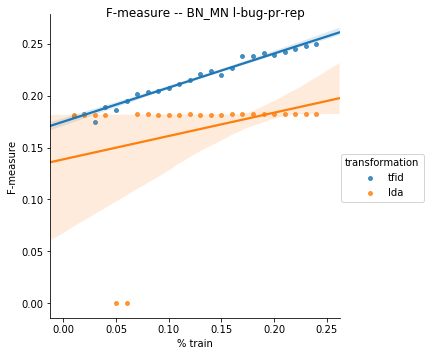

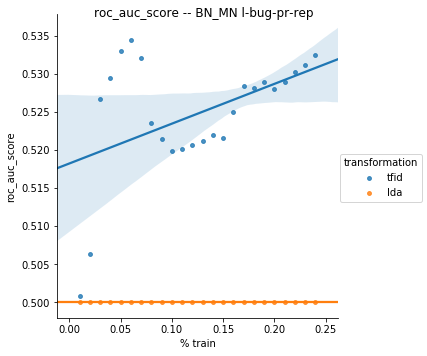

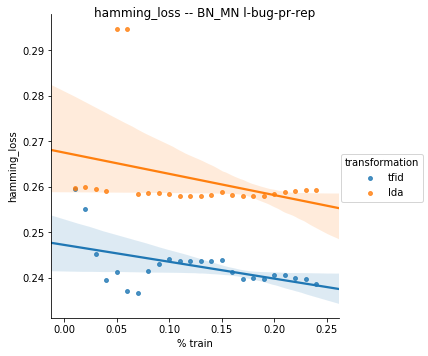

In [104]:
import pandas as pd
import seaborn as sns

#"BinaryRelevance(MultinomialNB()) + 'isLabeled','bug','isPullRequest','repo'"
strClassifier="BN_MN l-bug-pr-rep"
lmeasures=("F-measure","roc_auc_score","hamming_loss")
for measure in lmeasures:
    lm=sns.lmplot(x="% train",y=measure,data=dfresulty1,hue="transformation",scatter_kws={"s":15})
    fig=lm.fig
    fig.suptitle(measure +" -- " +strClassifier)

## Evaluate classifier MultiLabel: DecisionTreeClassifier

Preconditions
- use a classifier Multilabel
- use a metric multiclass (micro, macro) 
- issue.repor the number of repositories parsered is two

Data binary to classify: issue.repo,issue.isLabeled, issue.bug,issue.isPullRequest

Example issue.repo for two repoitories
  
df.replace('jquerytools', 0).replace('Chart.js', 1)

In [38]:
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance

from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score

from  sklearn import metrics

import numpy as np
import gensim
import pandas as pd

#ldacorpus = corpora.MmCorpus("./models/issue/isldatfidcorpus.mm")
#svlda=gensim.matutils.corpus2csc(ldacorpus)
#lda mallet version
ldacorpus = corpora.MmCorpus("./models/issue/isldamallettfidcorpus.mm")
svlda=gensim.matutils.corpus2csc(ldacorpus)


tfid_mm_corpus = corpora.MmCorpus('./models/issue/istfidcorpus.mm')
svtfid=gensim.matutils.corpus2csc(tfid_mm_corpus)

totalfiles,totalinstances,lprbt,df=loadCsvPullRequestFolder(path="./datasets/issue/") 
df = df.replace('true', 1).replace('false', 0)

#df = df.replace('jquerytools', 1).replace('Chart.js', 0)
df = df.replace('jquerytools', 0).replace('Chart.js', 1).replace('netty', 2).replace('RxJava', 3).replace('cakephp', 4).replace('angular.js', 5)

# Calcula F-Measure iterativamente obtenida con claificador Multinomial
# se analiza reduciendo el porcentaje de entrenamiento
def trainCorpusEvaluateDecisionTree(df,list_y,x_transformations):
    """Create a DecisionTreeClassifier multilabel classifier and it is trained iterative from train_size 1% to 40%.
    Measure are calculated FMeasure, Roc, hamming_loss,accuracy
    Parameters:
    ----------
    df: dataframe with issue information with class multiclass
    x_transformations : sparse vector with the corpus
    str_y_columname: binary class name in dataframe 
    Returns:
    -------  
    dfresult - list with measures values for each trained set
    """
    dfresult=pd.DataFrame(columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss"])
    for transformation in x_transformations:
        for i in range(1,25,1):
            train_size=i/100
            #X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[str_y_columname]), train_size=train_size, random_state = 0)
            X_train, X_test, y_train, y_test = train_test_split(transformation[1].transpose(), np.array(df[[list_y[0],list_y[1],list_y[2]]]), train_size=train_size, random_state = 0)
            #np.array(df[[list_y[0],list_y[1],list_y[2],list_y[3]]])
            #clf = MultinomialNB().fit(X_train, y_train)
            clf= DecisionTreeClassifier().fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            #print(y_test_predicted.shape)
            #print(y_train)
    
            f1=f1_score(y_test,y_test_predicted,average='macro')
            
            #scores = np.r_[y_test_predicted, y_test]
            #y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
            #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predicted)
            #roc = metrics.auc(fpr, tpr)
            #y_test_predicted_dense=gensim.matutils.sparse2full(y_test_predicted,4)
            roc = metrics.roc_auc_score(y_test,y_test_predicted,average='macro')
            
            #roc=roc_auc_score(y_test,y_test_predicted,average='macro')
            hamming=hamming_loss(y_test,y_test_predicted)
            #print("train_size: {} transformation[0]: {} ,f1: {}".format(train_size,transformation[0],f1))
            dfaux=pd.DataFrame([[train_size,transformation[0],f1,roc,hamming]],columns=["% train","transformation","F-measure","roc_auc_score","hamming_loss"])
            dfresult=dfresult.append(dfaux)
    return dfresult

dfresulty1=trainCorpusEvaluateDecisionTree(df,['isLabeled','bug','isPullRequest'],[["tfid",svtfid],["lda",svlda]])


./datasets/issue/all-issues_cakephp.arff.csv
./datasets/issue/all-issues_jquerytools.arff.csv
./datasets/issue/all-issues_chartjs.arff.csv
./datasets/issue/all-issues_angularjs.arff.csv
./datasets/issue/all-issues_vissoft14.arff.csv
./datasets/issue/all-issues_rxjava.arff.csv


/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/clopezno/anaconda3/envs/TextMining/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


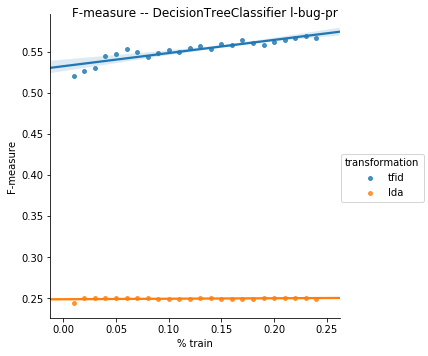

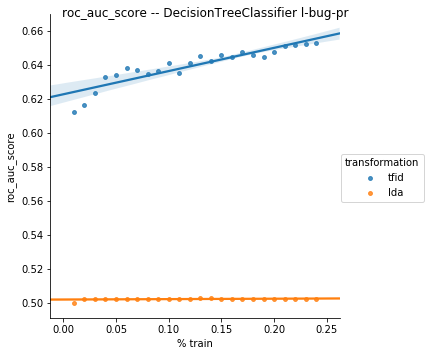

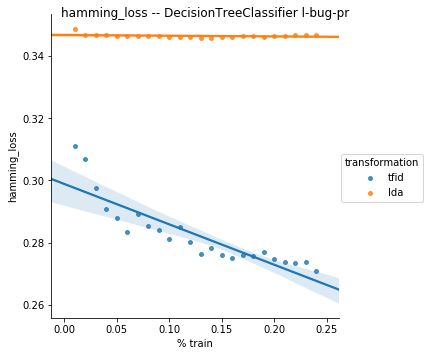

In [39]:
import pandas as pd
import seaborn as sns

#"DecisionTreeClassifier + 'isLabeled','bug','isPullRequest','repo'"
strClassifier="DecisionTreeClassifier l-bug-pr"
lmeasures=("F-measure","roc_auc_score","hamming_loss")
for measure in lmeasures:
    lm=sns.lmplot(x="% train",y=measure,data=dfresulty1,hue="transformation",scatter_kws={"s":15})
    fig=lm.fig
    fig.suptitle(measure +" -- " +strClassifier)